# **💎 Language Modeling 💎**


# **1. Import Libs**

## **1-1. Install libraries**

In [ ]:
!rm -rf /content/sample_data

In [ ]:
pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.2 MB/s eta 0:00:00


In [ ]:
!pip install -q portalocker>=2.0.0

In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


## **1-1. Import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm
import wandb

import os
from collections import Counter

import ipywidgets as widgets
from IPython.display import display

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchtext --> 0.16.0+cpu
tqdm --> 4.66.1


#  **2. Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Number of trainale parameters

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **3. Arguments**

In [ ]:
seed = 8

batch_size = 80
seq_len = 70

embedding_dim = 400

num_layers = 3
hidden_dim = 1150

dropoute = 0.1         #embedding
dropouti = 0.65      #lstm input / embedding output
dropouth = 0.3       #lstm hidden states
dropouto = 0.4       #lstm output

weight_drop = 0.5 # on recurrent matrix of lstm (U matrix)

lr = 8
wd = 1e-6
momentum = 0.9

clip = 0.25

wandb_enable = True

In [ ]:
wandb_arg_name = input('Please input the WandB argument (run) name:')

In [ ]:
wandb_arg_name

#  **4. Dataset**

##  **4-1. Download & Unzip the Dataset**

In [ ]:
train_iter, valid_iter, test_iter = WikiText2('/content/')

In [ ]:
train_iter_ = iter(train_iter)
train_iter_

<generator object ShardingFilterIterDataPipe.__iter__ at 0x799bc6ba0d60>

In [ ]:
next(train_iter_)

' \n'

## **4-2. Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [ ]:
!mv /content/datasets/WikiText2/wikitext-2/wiki.train.tokens /content/datasets/WikiText2/wikitext-2/wiki_train_tokens.txt

In [ ]:
f_train = open('/content/datasets/WikiText2/wikitext-2/wiki_train_tokens.txt')

In [ ]:
f_train2 = f_train.readlines()

In [ ]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, f_train2), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [ ]:
len(vocab)

28782

In [ ]:
vocab(['saeideh', 'hi', 'how', 'tehran', 'ali', 'valkyria'])

[0, 9206, 416, 23311, 2284, 3849]

In [ ]:
torch.save(vocab, 'vocab.pt')

In [ ]:
!cp /content/vocab.pt /content/drive/MyDrive/Howsam_Language_Modeling

## **4-3. EDA**

**how many paragraph:**

In [ ]:
len(f_train2)

36718

In [ ]:
f_train2[3]

' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n'

In [ ]:
main_tokens = list(map(tokenizer, f_train2))

In [ ]:
len(main_tokens)

36718

In [ ]:
vocab_dicts = {}
for i in main_tokens:
  for j in i:
    if j not in vocab_dicts.keys():
      vocab_dicts[j] = 1
    else:
      vocab_dicts[j] += 1

In [ ]:
len(vocab_dicts.keys())

28782

**all words in train.txt:**

In [ ]:
count_totall_word = 0
for i in main_tokens:
  for j in i:
    count_totall_word = count_totall_word + len(j)
count_totall_word

8618752

**Most and least common words:**

In [ ]:
# count = 0
count_dict2 = {}
for k, v in vocab_dicts.items():
  # count=count +1
  if v in count_dict2.keys():
    count_dict2[v]+=1
  else:
    count_dict2[v]=1

  # print(f"count {count}: ", k ," ", v)

In [ ]:
count_dict2

{29570: 1,
 54: 63,
 53: 63,
 231: 4,
 5: 2261,
 1702: 1,
 1601: 1,
 54625: 1,
 11992: 1,
 255: 6,
 3: 5130,
 102615: 1,
 29: 154,
 83397: 1,
 57030: 1,
 130768: 1,
 38: 91,
 12004: 1,
 119: 16,
 206: 8,
 39521: 1,
 15058: 1,
 309: 2,
 212: 7,
 11691: 1,
 36523: 1,
 32: 143,
 598: 1,
 16906: 1,
 342: 4,
 725: 2,
 2077: 1,
 429: 3,
 12718: 1,
 9: 991,
 50735: 1,
 262: 4,
 87: 35,
 13794: 1,
 124: 15,
 33: 105,
 979: 2,
 45015: 1,
 693: 2,
 519: 1,
 9273: 1,
 716: 1,
 1498: 1,
 45: 78,
 271: 5,
 2607: 1,
 103: 22,
 3877: 1,
 24: 206,
 545: 1,
 194: 7,
 66: 42,
 4242: 1,
 128: 22,
 12: 646,
 576: 1,
 197: 4,
 104: 22,
 2690: 1,
 1465: 1,
 1370: 1,
 3029: 1,
 113: 17,
 132: 9,
 624: 1,
 325: 2,
 4714: 1,
 1272: 1,
 93: 31,
 8: 1100,
 1102: 1,
 505: 2,
 611: 1,
 65: 52,
 2137: 1,
 856: 1,
 126: 16,
 1083: 2,
 180: 7,
 15140: 1,
 589: 3,
 2127: 1,
 181: 5,
 338: 1,
 3842: 1,
 46: 80,
 1584: 1,
 457: 2,
 2402: 1,
 641: 2,
 55: 61,
 70: 45,
 1448: 1,
 441: 2,
 9229: 1,
 407: 1,
 11: 686,
 957:

In [ ]:
from collections import OrderedDict
dict1 = OrderedDict(sorted(count_dict2.items()))
print(dict1)

OrderedDict([(3, 5130), (4, 3243), (5, 2261), (6, 1740), (7, 1389), (8, 1100), (9, 991), (10, 794), (11, 686), (12, 646), (13, 515), (14, 448), (15, 414), (16, 385), (17, 327), (18, 291), (19, 292), (20, 277), (21, 245), (22, 260), (23, 213), (24, 206), (25, 175), (26, 211), (27, 155), (28, 141), (29, 154), (30, 161), (31, 127), (32, 143), (33, 105), (34, 126), (35, 118), (36, 107), (37, 104), (38, 91), (39, 100), (40, 93), (41, 94), (42, 101), (43, 76), (44, 83), (45, 78), (46, 80), (47, 85), (48, 61), (49, 61), (50, 64), (51, 60), (52, 58), (53, 63), (54, 63), (55, 61), (56, 55), (57, 55), (58, 54), (59, 51), (60, 45), (61, 50), (62, 39), (63, 45), (64, 50), (65, 52), (66, 42), (67, 46), (68, 38), (69, 45), (70, 45), (71, 43), (72, 43), (73, 37), (74, 25), (75, 39), (76, 30), (77, 28), (78, 27), (79, 34), (80, 27), (81, 32), (82, 43), (83, 29), (84, 29), (85, 29), (86, 21), (87, 35), (88, 26), (89, 27), (90, 30), (91, 26), (92, 24), (93, 31), (94, 22), (95, 27), (96, 24), (97, 19), (

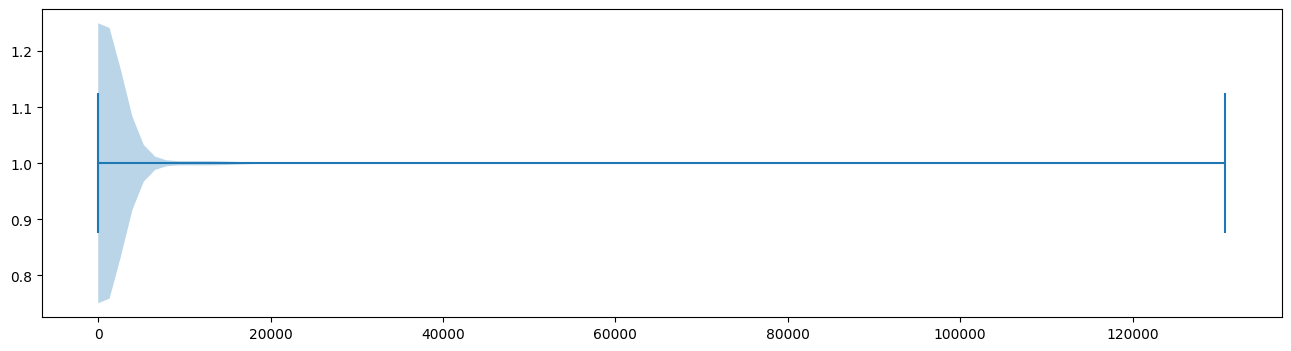

In [ ]:
plt.figure(figsize=(16, 4))
plt.violinplot(dict1, vert=False);

In [ ]:
freqs = Counter()
for tokens in map(tokenizer, f_train2):
  freqs.update(tokens)

In [ ]:
freqs.most_common()[:10]

[('the', 130768),
 (',', 102615),
 ('.', 83397),
 ('of', 57030),
 ('<unk>', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('a', 36523),
 ('=', 29570)]

In [ ]:
freqs.most_common()[-10:]

[('philipp', 3),
 ('prefaced', 3),
 ('kreutzer', 3),
 ('forrester', 3),
 ('zoromski', 3),
 ('roundabouts', 3),
 ('tuscola', 3),
 ('northeasterly', 3),
 ('intergrades', 3),
 ('gallinae', 3)]

## **4-4. Transform the data**

Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [ ]:
def data_process(raw_text_iter, seq_len):
  # Create a tensor that is concatenation of all tokens
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])

  M = len(data) // seq_len

  # We want to reshape our big tensor to M*L. To do this we should be confident that our shape of big tensor is divisible to seq_len
  # If it is not divisible, we add one element at the big tensor.
  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  # Put aside addition elements
  inputs = data[:M*seq_len]
  inputs = inputs.reshape(-1, seq_len)

  # Target is shifted input
  targets = data[1:M*seq_len+1]
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [ ]:
X_train, y_train = data_process(f_train2, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([29285, 70]),
 torch.Size([29285, 70]),
 torch.Size([3063, 70]),
 torch.Size([3063, 70]),
 torch.Size([3455, 70]),
 torch.Size([3455, 70]))

##  **4-5. Custom dataset**

In [ ]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    input = self.inputs[idx]
    target = self.targets[idx]
    return input, target


In [ ]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set = LanguageModelDataset(X_test, y_test)

In [ ]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23,     8,  5790,   299,    12,   575,
           232,    67,   452,    19, 13722,     5,   757,     3,  2500,    17,
             1,  1767,  5637,     3,   155,     6,   246,   354,     6,   976,
             2,    24,    23,     1,   237,    67,     6,     1,  3849,    93]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8,  5790,   299,    12,   575,   232,
            67,   452,    19, 13722,     5,   757,     3,  2500,    17,     1,
          1767,  5637,     3,   155,     6,   246,

In [ ]:
train_set[1]

(tensor([    3,     0,     1,   156,  4419,     4,  5790,     5,   729,    12,
            58,  2096,    14,    43,  7075,     2,     1,   333,  1085,  3218,
             7,     1,    37,    67,     5,  1694,     1, 11219,     2,     8,
         19698,   313,  1063,  2082,     1,  1702,     4, 19009,    56,     1,
            95, 25357,   107,    52,  1938,  1644,   288,   598,     5,    34,
         13620,   120,     1,  2321,  1063,     0, 14742,     3,     1,    67,
           135,   369,     6,   297,     2,  3245,    65,     8,   184,  1742]),
 tensor([    0,     1,   156,  4419,     4,  5790,     5,   729,    12,    58,
          2096,    14,    43,  7075,     2,     1,   333,  1085,  3218,     7,
             1,    37,    67,     5,  1694,     1, 11219,     2,     8, 19698,
           313,  1063,  2082,     1,  1702,     4, 19009,    56,     1,    95,
         25357,   107,    52,  1938,  1644,   288,   598,     5,    34, 13620,
           120,     1,  2321,  1063,     0, 14742,

## **4-6. Define dataloader**

In [ ]:
set_seed(seed)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([80, 70]), torch.Size([80, 70]))

#  **5. Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [ ]:
class WeightDrop(torch.nn.Module):

  def __init__(self, module, weights, dropout=0):
    super(WeightDrop, self).__init__()
    self.module = module
    self.weights = weights
    self.dropout = dropout
    self._setup()

  def widget_demagnetizer_y2k_edition(*args, **kwargs):
    return

  def _setup(self):
    if issubclass(type(self.module), torch.nn.RNNBase):
      self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

      for name_w in self.weights:
        print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
        w = getattr(self.module, name_w)
        del self.module._parameters[name_w]
        self.module.register_parameter(name_w + '_raw', nn.Parameter(w.data))

  def _setweights(self):
    for name_w in self.weights:
      raw_w = getattr(self.module, name_w + '_raw')
      w = None
      # w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
      mask = torch.nn.functional.dropout(torch.ones_like(raw_w), p=self.dropout, training=True) * (1 - self.dropout)
      setattr(self.module, name_w, raw_w * mask)

  def forward(self, *args):
    self._setweights()
    return self.module.forward(*args)

In [ ]:
# Dropout on embedding weights

def embedded_dropout(embed, words, dropout=0.1, scale=None):
  if dropout:
    mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(
        embed.weight) / (1 - dropout)
    masked_embed_weight = mask * embed.weight
  else:
    masked_embed_weight = embed.weight
  if scale:
    masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

  padding_idx = embed.padding_idx
  if padding_idx is None:
    padding_idx = -1

  embedding = torch.nn.functional.embedding(words, masked_embed_weight,
                                            padding_idx, embed.max_norm, embed.norm_type,
                                            embed.scale_grad_by_freq, embed.sparse)
  return embedding

In [ ]:
class LockedDropout(nn.Module):
  def __init__(self):
    super(LockedDropout, self).__init__()

  def forward(self, x, dropout):
    if not self.training or not dropout:
      return x

    #in first dimension we put 1,because we want that mask for all time steps be the same
    # 1 = seq lenght (L) // x.size(1) = batch size (B) // x.size(2) = embed dimension (f) ///// (position of L and B changed here)
    m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
    mask = m.requires_grad_(False) / (1 - dropout)
    mask = mask.expand_as(x)
    return mask * x

In [ ]:
class LanguageModel(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropoute=0.2, dropouti=0.2, dropouth=0.2, dropouto=0.2, weight_drop=0.2):
    super(LanguageModel, self).__init__()

    self.num_layers = num_layers

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    # self.dropout = nn.Dropout(p=dropout_embd)

    # batch_first=True : batch would be first dimension
    self.lstms = []
    # batch_first=False :: because input should be L*B*F (because of lockdrop)/ Before lockdrop it was B*L*F so we used to set batch_first=True
    # Although we could change the lockdrop code so we don't need to change the order of dimensions
    self.lstms.append(nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=0, batch_first=False))
    self.lstms.append(nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=0, batch_first=False))
    self.lstms.append(nn.LSTM(hidden_dim, embedding_dim, num_layers=1, dropout=0, batch_first=False))
    if weight_drop > 0:
      self.lstms = [WeightDrop(lstm, ['weight_hh_l0'], dropout=weight_drop) for lstm in self.lstms]
    self.lstms = nn.ModuleList(self.lstms)

    self.fc = nn.Linear(embedding_dim, vocab_size)

    # weght tying. identical address weight(we don't copy, just we set both address in ram identical)
    # It results less params
    self.embedding.weight =  self.fc.weight

    self.lockdrop = LockedDropout()
    self.dropoute = dropoute
    self.dropouti = dropouti
    self.dropouth = dropouth
    self.dropouto = dropouto


  def forward(self, src):
    #src = torch.Size([20, 35])
    embedding = embedded_dropout(self.embedding, src, dropout=self.dropoute if self.training else 0)
    embedding = self.lockdrop(embedding, self.dropouti)

    new_hidden =[]
    for l, lstm in enumerate(self.lstms):
      embedding, _ = lstm(embedding)
      if l != self.num_layers-1:
        embedding = self.lockdrop(embedding, self.dropouth)

    embedding = self.lockdrop(embedding, self.dropouto)

    # output, hidden = self.lstm(embed) # torch.Size([20, 35, 512])
    out = self.fc(embedding)

    return out

In [ ]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      num_layers=num_layers,
                      dropoute=dropoute, dropouti=dropouti,
                      dropouth=dropouth, dropouto=dropouto,weight_drop=weight_drop)
model

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0


LanguageModel(
  (embedding): Embedding(28782, 400)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(400, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 400)
    )
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [ ]:
# Number of parameters:
print('params of model : ', num_trainable_params(model))
print('params of embedding : ', num_trainable_params(model.embedding))
print('params of lstm : ', num_trainable_params(model.lstms))
print('params of fc :', num_trainable_params(model.fc))

params of model :  31.753182
params of embedding :  11.5128
params of lstm :  20.2116
params of fc : 11.541582


In [ ]:
model(x_batch.t()).shape, x_batch.shape

(torch.Size([70, 80, 28782]), torch.Size([80, 70]))

# **6. Config**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

In [ ]:
metric = tm.text.Perplexity().to(device)
metric

Perplexity()

In [ ]:
key_file = '/content/key.txt'

if os.path.exists(key_file):
    with open(key_file) as f:
        key = f.readline().strip()
    wandb.login(key=key)
else:
    print("Key file does not exist. Please create the key file with your wandb API key.")

#  **7. Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.t().to(device)
      targets = targets.t().to(device)

      outputs = model(inputs)

      # loss = loss_fn(outputs, targets)
      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss.backward()
      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

#  **8. Evaluation**

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.t().to(device)
      targets = targets.t().to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

#  **9. Training Process**

## **9-1. Train Model**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
set_seed(seed)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [ ]:
set_seed(seed)

model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      num_layers=num_layers,
                      dropoute=dropoute, dropouti=dropouti,
                      dropouth=dropouth, dropouto=dropouto,weight_drop=weight_drop).to(device)
model

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0


LanguageModel(
  (embedding): Embedding(28782, 400)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(400, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 400)
    )
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [ ]:
# Initialize wandb
if wandb_enable:
  wandb.init(
      project='Language_Model',
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'clip': clip,
      }
  )

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

#### **First_Try / lr = 8**

In [ ]:
lr = 8.0
wd = 1e-06
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
set_seed(seed)

num_epochs = 50

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1:   0%|          | 0/367 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Epoch 1: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=6.64, metric=769]


Model Saved!
Valid: Loss = 5.772, Metric = 322.6



Epoch 2: 100%|██████████| 367/367 [02:30<00:00,  2.45batch/s, loss=5.94, metric=380]


Model Saved!
Valid: Loss = 5.422, Metric = 227.6



Epoch 3: 100%|██████████| 367/367 [02:29<00:00,  2.45batch/s, loss=5.7, metric=299]


Model Saved!
Valid: Loss = 5.252, Metric = 192.1



Epoch 4: 100%|██████████| 367/367 [02:29<00:00,  2.45batch/s, loss=5.54, metric=254]


Model Saved!
Valid: Loss = 5.12, Metric = 168.3



Epoch 5: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=5.41, metric=225]


Model Saved!
Valid: Loss = 5.039, Metric = 155.2



Epoch 6: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=5.31, metric=203]


Model Saved!
Valid: Loss = 4.966, Metric = 144.2



Epoch 7: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=5.24, metric=188]


Model Saved!
Valid: Loss = 4.904, Metric = 135.5



Epoch 8: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=5.17, metric=176]


Model Saved!
Valid: Loss = 4.901, Metric = 135.0



Epoch 9: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=5.12, metric=167]


Model Saved!
Valid: Loss = 4.844, Metric = 127.7



Epoch 10: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=5.07, metric=159]


Model Saved!
Valid: Loss = 4.816, Metric = 124.1



Epoch 11: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=5.03, metric=152]


Model Saved!
Valid: Loss = 4.792, Metric = 121.1



Epoch 12: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.99, metric=146]


Model Saved!
Valid: Loss = 4.769, Metric = 118.3



Epoch 13: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.95, metric=141]


Model Saved!
Valid: Loss = 4.756, Metric = 116.8



Epoch 14: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.92, metric=137]


Model Saved!
Valid: Loss = 4.729, Metric = 113.7



Epoch 15: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.9, metric=134]


Model Saved!
Valid: Loss = 4.722, Metric = 112.8



Epoch 16: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.87, metric=130]


Model Saved!
Valid: Loss = 4.712, Metric = 111.7



Epoch 17: 100%|██████████| 367/367 [02:29<00:00,  2.45batch/s, loss=4.85, metric=127]


Model Saved!
Valid: Loss = 4.702, Metric = 110.7



Epoch 18: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.82, metric=124]


Model Saved!
Valid: Loss = 4.694, Metric = 109.7



Epoch 19: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.81, metric=123]


Model Saved!
Valid: Loss = 4.682, Metric = 108.5



Epoch 20: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.78, metric=120]


Model Saved!
Valid: Loss = 4.668, Metric = 106.9



Epoch 21: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.77, metric=117]


Valid: Loss = 4.672, Metric = 107.3



Epoch 22: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.76, metric=116]


Model Saved!
Valid: Loss = 4.654, Metric = 105.4



Epoch 23: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.74, metric=115]


Model Saved!
Valid: Loss = 4.652, Metric = 105.2



Epoch 24: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.72, metric=113]


Valid: Loss = 4.656, Metric = 105.6



Epoch 25: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.71, metric=111]


Model Saved!
Valid: Loss = 4.644, Metric = 104.4



Epoch 26: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.7, metric=110]


Model Saved!
Valid: Loss = 4.627, Metric = 102.6



Epoch 27: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.69, metric=109]


Model Saved!
Valid: Loss = 4.619, Metric = 101.8



Epoch 28: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.68, metric=108]


Valid: Loss = 4.653, Metric = 105.3



Epoch 29: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.67, metric=106]


Valid: Loss = 4.63, Metric = 102.9



Epoch 30: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.66, metric=106]


Valid: Loss = 4.627, Metric = 102.6



Epoch 31: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.65, metric=105]


Model Saved!
Valid: Loss = 4.614, Metric = 101.3



Epoch 32: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.63, metric=103]


Valid: Loss = 4.626, Metric = 102.6



Epoch 33: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.64, metric=103]


Model Saved!
Valid: Loss = 4.611, Metric = 101.0



Epoch 34: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.62, metric=102]


Model Saved!
Valid: Loss = 4.605, Metric = 100.3



Epoch 35: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.61, metric=101]


Model Saved!
Valid: Loss = 4.603, Metric = 100.2



Epoch 36: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.61, metric=101]


Model Saved!
Valid: Loss = 4.6, Metric = 99.9



Epoch 37: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.6, metric=99.1]


Valid: Loss = 4.613, Metric = 101.2



Epoch 38: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.6, metric=99.4]


Model Saved!
Valid: Loss = 4.598, Metric = 99.64



Epoch 39: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.58, metric=97.8]


Valid: Loss = 4.616, Metric = 101.5



Epoch 40: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.58, metric=98]


Valid: Loss = 4.61, Metric = 101.0



Epoch 41: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.57, metric=96.8]


Model Saved!
Valid: Loss = 4.593, Metric = 99.14



Epoch 42: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.57, metric=96.7]


Model Saved!
Valid: Loss = 4.592, Metric = 99.03



Epoch 43: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.56, metric=95.4]


Model Saved!
Valid: Loss = 4.589, Metric = 98.85



Epoch 44: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.56, metric=95.2]


Model Saved!
Valid: Loss = 4.585, Metric = 98.36



Epoch 45: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.55, metric=95]


Valid: Loss = 4.602, Metric = 100.1



Epoch 46: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.55, metric=94.8]


Model Saved!
Valid: Loss = 4.579, Metric = 97.79



Epoch 47: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.55, metric=94.6]


Valid: Loss = 4.598, Metric = 99.66



Epoch 48: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.54, metric=93.7]


Valid: Loss = 4.593, Metric = 99.18



Epoch 49: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.53, metric=92.9]


Valid: Loss = 4.581, Metric = 98.05



Epoch 50: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.54, metric=93.3]


Valid: Loss = 4.59, Metric = 98.91



In [ ]:
!cp '/content/model_46_WeightDrop_FirstT.pt' '/content/drive/MyDrive/'

#### **Second_Try / lr = 2**

In [ ]:
set_seed(seed)

model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      num_layers=num_layers,
                      dropoute=dropoute, dropouti=dropouti,
                      dropouth=dropouth, dropouto=dropouto,weight_drop=weight_drop).to(device)
model

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0


LanguageModel(
  (embedding): Embedding(28782, 400)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(400, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 400)
    )
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [ ]:
model = torch.load('/content/model_46_WeightDrop_FirstT.pt')

In [ ]:
lr = 2
wd = 1e-06
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
set_seed(seed)

num_epochs = 20

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.42, metric=83.2]


Model Saved!
Valid: Loss = 4.527, Metric = 92.86



Epoch 2: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.38, metric=79.8]


Model Saved!
Valid: Loss = 4.517, Metric = 91.93



Epoch 3: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.36, metric=78.4]


Model Saved!
Valid: Loss = 4.514, Metric = 91.68



Epoch 4: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.35, metric=77.5]


Model Saved!
Valid: Loss = 4.511, Metric = 91.35



Epoch 5: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.34, metric=76.7]


Model Saved!
Valid: Loss = 4.51, Metric = 91.32



Epoch 6: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=4.32, metric=75.5]


Valid: Loss = 4.511, Metric = 91.43



Epoch 7: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.32, metric=75.2]


Model Saved!
Valid: Loss = 4.505, Metric = 90.83



Epoch 8: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=4.31, metric=74.3]


Model Saved!
Valid: Loss = 4.504, Metric = 90.75



Epoch 9: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.3, metric=74]


Model Saved!
Valid: Loss = 4.503, Metric = 90.69



Epoch 10: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.29, metric=73.1]


Valid: Loss = 4.505, Metric = 90.86



Epoch 11: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.29, metric=73]


Model Saved!
Valid: Loss = 4.503, Metric = 90.69



Epoch 12: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=4.28, metric=72.4]


Model Saved!
Valid: Loss = 4.503, Metric = 90.62



Epoch 13: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.27, metric=71.9]


Model Saved!
Valid: Loss = 4.501, Metric = 90.5



Epoch 14: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.27, metric=71.7]


Model Saved!
Valid: Loss = 4.497, Metric = 90.16



Epoch 15: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.27, metric=71.4]


Valid: Loss = 4.505, Metric = 90.83



Epoch 16: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=4.26, metric=70.6]


Valid: Loss = 4.498, Metric = 90.17



Epoch 17: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.26, metric=70.5]


Valid: Loss = 4.5, Metric = 90.36



Epoch 18: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=4.25, metric=70.1]


Model Saved!
Valid: Loss = 4.497, Metric = 90.07



Epoch 19: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.25, metric=69.8]


Valid: Loss = 4.497, Metric = 90.14



Epoch 20: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.23, metric=69.1]


Model Saved!
Valid: Loss = 4.496, Metric = 90.02



In [ ]:
!cp '/content/model_20_WeightDrop_SecondT.pt' /content/drive/MyDrive

#### **Third_Try / lr = 0.01**

In [ ]:
set_seed(seed)

model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim,
                      num_layers=num_layers,
                      dropoute=dropoute, dropouti=dropouti,
                      dropouth=dropouth, dropouto=dropouto,weight_drop=weight_drop).to(device)
model

Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0
Applying weight drop of 0.5 to weight_hh_l0


LanguageModel(
  (embedding): Embedding(28782, 400)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(400, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 400)
    )
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [ ]:
model = torch.load('/content/model_20_WeightDrop_SecondT.pt')

In [ ]:
lr = 0.01
wd = 1e-06
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
set_seed(seed)

num_epochs = 5

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=4.16, metric=64.2]


Model Saved!
Valid: Loss = 4.491, Metric = 89.59



Epoch 2: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.14, metric=63.2]


Model Saved!
Valid: Loss = 4.491, Metric = 89.56



Epoch 3: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.14, metric=62.7]


Model Saved!
Valid: Loss = 4.491, Metric = 89.54



Epoch 4: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.13, metric=62.5]


Valid: Loss = 4.491, Metric = 89.55



Epoch 5: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.13, metric=62.1]


Model Saved!
Valid: Loss = 4.49, Metric = 89.46



In [ ]:
set_seed(seed)

num_epochs = 5

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.15, metric=63.2]


Model Saved!
Valid: Loss = 4.489, Metric = 89.43



Epoch 2: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.13, metric=62.5]


Valid: Loss = 4.49, Metric = 89.46



Epoch 3: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.13, metric=62.2]


Valid: Loss = 4.49, Metric = 89.46



Epoch 4: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.13, metric=62]


Valid: Loss = 4.49, Metric = 89.48



Epoch 5: 100%|██████████| 367/367 [02:30<00:00,  2.43batch/s, loss=4.12, metric=61.6]


Model Saved!
Valid: Loss = 4.489, Metric = 89.41



In [ ]:
set_seed(seed)

num_epochs = 5

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model_{epoch}.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  epoch_counter += 1

Epoch 1: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.14, metric=62.8]


Model Saved!
Valid: Loss = 4.489, Metric = 89.38



Epoch 2: 100%|██████████| 367/367 [02:30<00:00,  2.44batch/s, loss=4.13, metric=62.1]


Valid: Loss = 4.489, Metric = 89.42



Epoch 3: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.12, metric=61.8]


Valid: Loss = 4.489, Metric = 89.43



Epoch 4: 100%|██████████| 367/367 [02:31<00:00,  2.42batch/s, loss=4.12, metric=61.7]


Valid: Loss = 4.49, Metric = 89.45



Epoch 5: 100%|██████████| 367/367 [02:31<00:00,  2.43batch/s, loss=4.11, metric=61.4]


Model Saved!
Valid: Loss = 4.489, Metric = 89.38



In [ ]:
!cp '/content/model_15_WeightDrop_ThirdT.pt' /content/drive/MyDrive

In [ ]:
wandb.finish()

loss_train,█▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss_valid,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metric_train,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metric_valid,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_train,4.1145
loss_valid,4.48872
metric_train,61.35825
metric_valid,89.3847


##  **9-2. Plot**

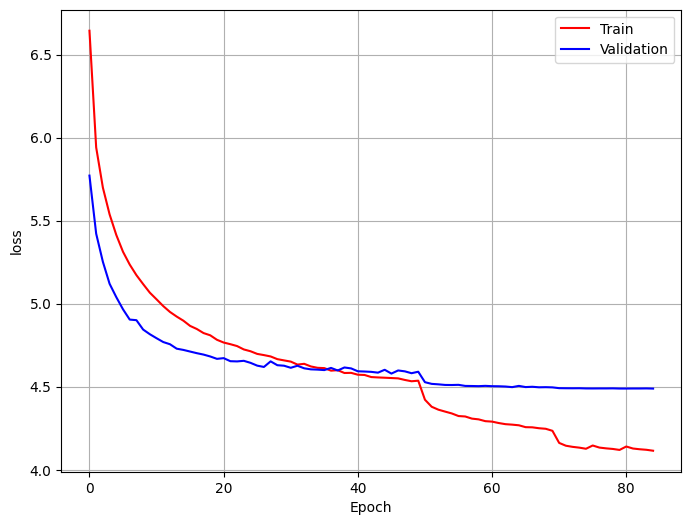

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

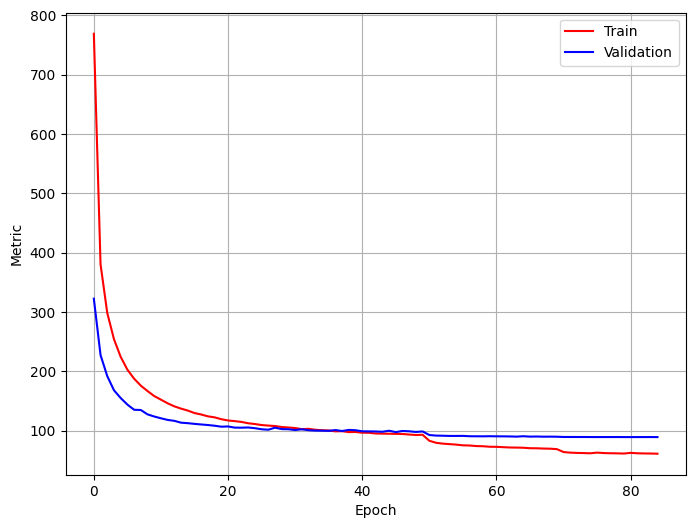

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), metric_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), metric_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.grid(True)
plt.legend()

# **10. Test**

In [ ]:
model_path = '/content/model_15_WeightDrop_ThirdT.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 400)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(400, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 400)
    )
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [ ]:
loss_test, metric_test = evaluate(model, test_loader, loss_fn, metric)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [ ]:
loss_test, metric_test

(4.447207922285253, 85.26044464111328)

# **11. Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model_path = '/content/model_15_WeightDrop_ThirdT.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 400)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(400, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 400)
    )
  )
  (fc): Linear(in_features=400, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [ ]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)

    with torch.no_grad():
      prediction = model(src)

    # Method 1
    # idx = torch.argmax(prediction[-1])
    # itos = vocab.get_itos()
    # itos[idx]

    # Method 2
    probs = torch.softmax(prediction[-1]/temperature, dim=0)

    idx = vocab['<ukn>']
    while idx == vocab['<ukn>']:
      idx = torch.multinomial(probs, num_samples=1).item()

    token = itos[idx]
    prompt += ' ' + token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [ ]:
examples = ['In a galaxy far, far away, there',
            'The sun was setting in the',
            'Once upon a time, there lived a young princess named',
            'What is the meaning ',
            'in the remaining days of this year i',
            'what should i']
seed = 45
for i, example in enumerate(examples):
  print(f"example {i}:")
  print(generate(example, 35, 0.5, model, tokenizer, vocab, seed))
  print()

example 0:
In a galaxy far, far away, there is a small quantity of water in the center of the soil .

example 1:
The sun was setting in the early 80s , and the star was also the first planet to be used for a few years .

example 2:
Once upon a time, there lived a young princess named the family .

example 3:
What is the meaning  of a planet is the star , and the star , which is a major astronomical center , is a part of the solar system .

example 4:
in the remaining days of this year i had been in the accident .

example 5:
what should i have been done .

